### Simulate energy deposit of a gamma-ray inside the water cherenkov tank 
To start, consider pair-production as the only interaction, remember that the energy threshold is two times the electron mass.\ 
Use the following assumptions: 
    * Cross section = 7/9 of radiation length     
    * Electron and positrons are produced along same direction as the gamma-ray 
    * Gamma-ray energy is split in half between electron and positron       
    

In [174]:
# First of all execute python script to load the defined functions 

%run functions.py

In [175]:
import numpy as np  
from astropy import units as u
import matplotlib.pyplot as plt
import copy

# Define gamma-ray energy 

ek0 = 1000 * u.MeV


In [176]:
# Look up material properties (water)
# https://pdg.lbl.gov/2024/AtomicNuclearProperties/HTML/water_liquid.html  

Z_A=0.55509 *u.mol / u.g #mol g^-1, atomic number Z over atomic mass mol g^-1 
rho=1 * u.g / u.cm**3 #g cm^-3, density of liquid water 
I=7.97e-5 * u.MeV #MeV, mean excitation energy

K=0.307075 * u.MeV * u.cm **2 / u.mol #MeV mol^−1 cm2
Ec = 78.60 * u.MeV
X0 = 36.08 * u.cm 

In [177]:
# Extract point of first interaction 

int_length = 7./9 * X0

ek0_elec = 0. * u.MeV
ek0_pos = 0. * u.MeV
z_int = 0. * u.cm

if(ek0 > 2*me): 
    z_int = np.random.exponential(int_length.value, size=1)[0] * u.cm  
    ek0_elec = ek0_pos = (ek0 - me) /2
    print('Pair production conversion happens at:', z_int)
    print('e- produced with energy: ',ek0_elec)
    print('e+ produced with energy: ',ek0_pos)
    
else: print('Gamma-ray energy below pair production threshold!\n ') 
 

Pair production conversion happens at: 32.269916506811974 cm
e- produced with energy:  499.744500525 MeV
e+ produced with energy:  499.744500525 MeV


In [178]:
# Compute energy deposited by produced electron and positron as a function of height inside the tank 

htank = 120 * u.cm 
dx = 1 * u.cm 
nsteps = int((htank-z_int)/dx)
d = copy.deepcopy(z_int) # Copying without reference   

ek_elec = ek0_elec
ek_pos = ek0_pos
etot_loss = 0. * u.MeV

tot_eloss_elec_array = [] 
tot_eloss_pos_array = [] 
tot_eloss_array = [] 
d_array = []

for i_step in range(nsteps): 
    d += dx 
    d_array.append(d.value)
    
    eloss_elec = de_dx_elec_tot(ek_elec, K, Z_A, I, rho, X0) * dx 
    eloss_pos = de_dx_elec_tot(ek_pos, K, Z_A, I, rho, X0) * dx 
    
    ek_elec = ek_elec - eloss_elec
    ek_pos = ek_pos - eloss_pos

    etot_loss += (eloss_elec + eloss_pos)

    tot_eloss_elec_array.append(eloss_elec.value)
    tot_eloss_pos_array.append(eloss_pos.value)
    tot_eloss_array.append(eloss_elec.value + eloss_pos.value )
    
    if(ek_elec.value < 0.1): 
        print('Electron energy below 100 keV, terminate')
        break  
    
print('Total energy loss: ',etot_loss)


Electron energy below 100 keV, terminate
Total energy loss:  1000.1536821180537 MeV


32.269916506811974


Text(33.269916506811974, 4, 'Interaction point')

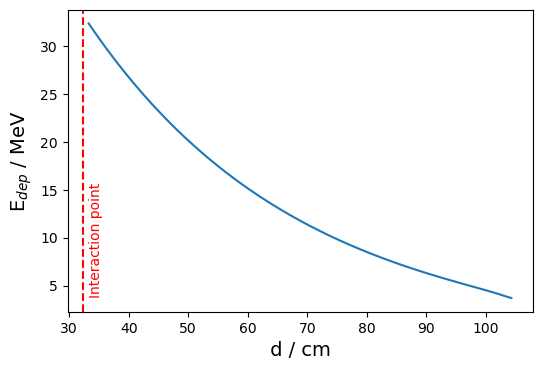

In [179]:
plt.figure(dpi=100)

plt.plot(d_array,tot_eloss_array)

plt.xlabel(' d / cm ', size=14)
plt.ylabel(r'E$_{dep}$ / MeV',size=14)

print(z_int.value)
plt.axvline(z_int.value, linestyle='--', color='red' )
plt.text(z_int.value+1,4,'Interaction point',color='red',rotation=90)

#plt.yscale('log')



In [180]:
# Consider 100 gamma-rays with starting energy of 1 GeV, transversing the water tank. 
# Produce a histogram of the enregy deposited in the first 20 cm of water

def gamma_eloss_array(ek, K, Z_A, I, rho, X0, htank, dx):   

    ek0_elec = 0. * u.MeV
    ek0_pos = 0. * u.MeV
    z_int = 0. * u.cm

    if(ek0 > 2*me): 
        z_int = np.random.exponential(int_length.value, size=1)[0] * u.cm  
        ek0_elec = ek0_pos = (ek0 - me) /2
        #print('Pair production conversion happens at:', z_int)
        #print('e- produced with energy: ',ek0_elec)
        #print('e+ produced with energy: ',ek0_pos)
    
    else: print('Gamma-ray energy below pair production threshold!\n ') 

    nsteps = int((htank-z_int)/dx)
    d = z_int

    ek_elec = ek0_elec
    ek_pos = ek0_pos
    etot_loss = 0. * u.MeV

    tot_eloss_elec_array = [] 
    tot_eloss_pos_array = [] 
    tot_eloss_array = [] 
    d_array = []

    for i_step in range(nsteps): 
        d += dx 
        d_array.append(d.value)
    
        eloss_elec = de_dx_elec_tot(ek_elec, K, Z_A, I, rho, X0) * dx 
        eloss_pos = de_dx_elec_tot(ek_pos, K, Z_A, I, rho, X0) * dx 
    
        ek_elec = ek_elec - eloss_elec
        ek_pos = ek_pos - eloss_pos

        etot_loss += (eloss_elec + eloss_pos)

        tot_eloss_elec_array.append(eloss_elec.value)
        tot_eloss_pos_array.append(eloss_pos.value)
        tot_eloss_array.append(eloss_elec.value + eloss_pos.value )
    
        if(ek_elec.value < 0.1): 
            #print('Electron energy below 100 keV, terminate')
            break  
        
    return np.asarray(tot_eloss_array), np.asarray(d_array)
    

In [184]:
# Launch gamma-ray N times 

N_gamma = 500
ek0_gamma = 1 * u.GeV
eloss_40cm = []  


for i in range(500):
    tot_eloss_array, d_array = gamma_eloss_array(ek0, K, Z_A, I, rho, X0, htank, dx) 
    d_mask = d_array < 40  
    eloss_40cm.append( np.sum(tot_eloss_array[d_mask]) )


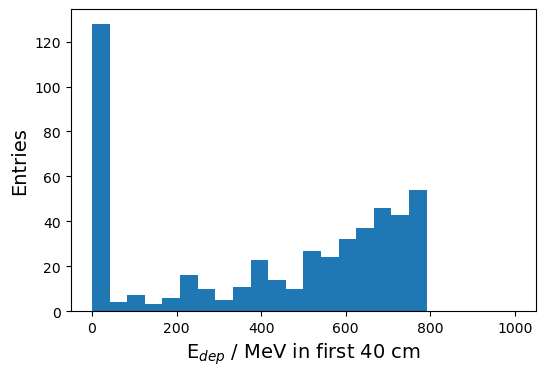

In [186]:
plt.figure(dpi=100)

plt.xlabel(r'E$_{dep}$ / MeV in first 40 cm', size=14)
plt.ylabel('Entries', size=14)
h = plt.hist(eloss_40cm, bins=np.linspace(0,1000,25))